# Training a CNN for Image-Regression to predict the SDAS of a given image

In [1]:
!pip install opencv-python


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np        #library for matrices (useful for data preparation)
import os                 #library for package manage
import cv2                #library for loading images
import tensorflow as tf   #library/framework for all kinds of machine learning tasks
import matplotlib.pyplot as plt #libary for visualisation
import random             #for random seeds

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Input, Lambda
from tensorflow.keras.initializers import Constant, he_normal

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator #for Augmentation of Training Data

from tqdm.keras import TqdmCallback # for loading-bar
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

2025-05-14 11:12:03.527859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747221123.541857  471130 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747221123.546035  471130 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747221123.558285  471130 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747221123.558297  471130 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747221123.558299  471130 computation_placer.cc:177] computation placer alr

In [3]:
!nvidia-smi

Wed May 14 11:12:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A30                     On  |   00000000:21:00.0 Off |                   On |
| N/A   32C    P0             57W /  165W |                  N/A   |     N/A      Default |
|                                         |                        |              Enabled |
+-----------------------------------------+-----

In [4]:
# speicher test 

In [5]:
# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
gpus
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2562203191268745787
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1113456640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16321720269310575134
physical_device_desc: "device: 0, name: NVIDIA A30 MIG 4g.24gb, pci bus id: 0000:21:00.0, compute capability: 8.0"
xla_global_id: 416903419
]


I0000 00:00:1747221126.826209  471130 gpu_device.cc:2019] Created device /device:GPU:0 with 1061 MB memory:  -> device: 0, name: NVIDIA A30 MIG 4g.24gb, pci bus id: 0000:21:00.0, compute capability: 8.0


fix random seed. Always use a fixed random seed to guarantee that when you run the code twice you will get the same outcome. This removes a factor of variation and will help keep you sane.

In [6]:
# 1. Python-Seed für allgemeine Zufallszahlen
random.seed(42)

# 2. NumPy-Seed für alle Operationen mit NumPy
np.random.seed(42)

# 3. TensorFlow-Seed für TensorFlow-Operationen
tf.random.set_seed(42)

# 4. Optional: OS-Level Seed für bestimmte Bibliotheken
os.environ['PYTHONHASHSEED'] = '42'

## Model Architecture

In [7]:
# 🔁 Benannte Funktion zum Konvertieren Graustufen -> RGB
def to_rgb(x):
    return tf.image.grayscale_to_rgb(x)

# 📥 Input Layer (Graustufenbild)
input_layer = Input(shape=(200, 200, 1))

# 🔄 Konvertiere Graustufen zu 3-Kanal RGB
x = Lambda(to_rgb, output_shape=(200, 200, 3), name="grayscale_to_rgb")(input_layer)

# 📦 ResNet50 ohne Klassifikationskopf
resnet_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(200, 200, 3)
)

# ❄️ Einfrieren der ResNet50-Gewichte
for layer in resnet_base.layers:
    layer.trainable = False

# 🔄 Durch ResNet schicken
x = resnet_base(x)

# 🔄 Flatten + Dense + Regression
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(1, activation='linear', kernel_initializer=he_normal())(x)

# 🧠 Modell zusammensetzen
model = Model(inputs=input_layer, outputs=output)

# 🛠️ Kompilieren
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='mse', metrics=['RootMeanSquaredError'])

I0000 00:00:1747221126.854651  471130 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1061 MB memory:  -> device: 0, name: NVIDIA A30 MIG 4g.24gb, pci bus id: 0000:21:00.0, compute capability: 8.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [8]:
learning_rate = 0.00001 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Modell kompilieren
model.compile(optimizer=optimizer, loss='mse', metrics=['RootMeanSquaredError']) #mse = mean sqaured error learning_rate=0.0005

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ grayscale_to_rgb (Lambda)       │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,010,625 (114.48 MB)

 Trainable params: 6,422,785 (24.50 MB)

 Non-trainable params: 23,587,840 (89.98 MB)

## Import Dataset and Preprocessing

In [10]:
# Path to the folder containing the original images (no subfolders)
data_dir = r'../data/bmw_train'
image_exts = ('.jpeg', '.jpg', '.bmp', '.png')
pixel_per_micrometer = 1/0.728265817023213 # for our training data from bmw
F_value = 1.36/pixel_per_micrometer        # F_value from paper

# List all image filenames
files = [f for f in os.listdir(data_dir) if f.lower().endswith(image_exts)] 

tiles = []
labels = []
tile_size = 200

for idx, file in enumerate(files, 1):
    img_path = os.path.join(data_dir, file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"⚠️ Could not load {file}, skipping.")
        continue

    # --- Extract label from filename exactly as in the original script ---
    try:
        filename_parts = file.split('_')
        if len(filename_parts) < 2:
            print(f"⚠️ Unexpected filename format: {file}")
            continue
        sdas_value_str = filename_parts[1]   # e.g., '33' from 'AC_33_B2.jpg'
        SDAS = float(sdas_value_str)         # Convert string to float
        s_value = round(SDAS / F_value, 2)  # Apply formula
    except Exception as e:
        print(f"⚠️ Error parsing label from '{file}': {e}")
        continue
        
    norm_label = s_value / 100.0  # Normalize to 0–1 range

    h, w = img.shape

    # Split image into 200×200 tiles
    for y in range(0, h, tile_size):
        for x in range(0, w, tile_size):
            tile = img[y:y+tile_size, x:x+tile_size]
            if tile.shape != (tile_size, tile_size):
                continue  # Skip incomplete tiles at the edges

            # Normalize pixel values and add channel dimension
            tile = tile.astype(np.float16) / 255.0
            tile = tile[..., np.newaxis]  # Shape: (200, 200, 1)

            tiles.append(tile)
            labels.append(norm_label)

            # Apply 90°, 180°, and 270° rotations and store them as additional samples
            # for k in [1, 2, 3]:  # 1 = 90°, 2 = 180°, 3 = 270°
            #     rotated = np.rot90(tile, k)  # Rotate k times 90° counter-clockwise
            #     tiles.append(rotated)
            #     labels.append(norm_label)

    if idx % 50 == 0:
        print(f"⏳ Processed {idx}/{len(files)} images...")

# Convert lists to NumPy arrays
input_data = np.array(tiles, dtype=np.float16)
labels     = np.array(labels, dtype=np.float16)

print(f"✅ Done: {input_data.shape[0]} tiles created, input shape {input_data.shape[1:]}")

⏳ Processed 50/130 images...
⏳ Processed 100/130 images...
✅ Done: 12870 tiles created, input shape (200, 200, 1)


Processing file 18711/30685
Processing file 18712/30685
Processing file 18713/30685
Processing file 18714/30685
Processing file 18715/30685
Processing file 18716/30685
Processing file 18717/30685
Processing file 18718/30685
Processing file 18719/30685
Processing file 18720/30685
Processing file 18721/30685
Processing file 18722/30685
Processing file 18723/30685
Processing file 18724/30685
Processing file 18725/30685
Processing file 18726/30685
Processing file 18727/30685
Processing file 18728/30685
Processing file 18729/30685
Processing file 18730/30685
Processing file 18731/30685
Processing file 18732/30685
Processing file 18733/30685
Processing file 18734/30685
Processing file 18735/30685
Processing file 18736/30685
Processing file 18737/30685
Processing file 18738/30685
Processing file 18739/30685
Processing file 18740/30685
Processing file 18741/30685
Processing file 18742/30685
Processing file 18743/30685
Processing file 18744/30685
Processing file 18745/30685
Processing file 1874

Processing file 19296/30685
Processing file 19297/30685
Processing file 19298/30685
Processing file 19299/30685
Processing file 19300/30685
Processing file 19301/30685
Processing file 19302/30685
Processing file 19303/30685
Processing file 19304/30685
Processing file 19305/30685
Processing file 19306/30685
Processing file 19307/30685
Processing file 19308/30685
Processing file 19309/30685
Processing file 19310/30685
Processing file 19311/30685
Processing file 19312/30685
Processing file 19313/30685
Processing file 19314/30685
Processing file 19315/30685
Processing file 19316/30685
Processing file 19317/30685
Processing file 19318/30685
Processing file 19319/30685
Processing file 19320/30685
Processing file 19321/30685
Processing file 19322/30685
Processing file 19323/30685
Processing file 19324/30685
Processing file 19325/30685
Processing file 19326/30685
Processing file 19327/30685
Processing file 19328/30685
Processing file 19329/30685
Processing file 19330/30685
Processing file 1933

Processing file 19608/30685
Processing file 19609/30685
Processing file 19610/30685
Processing file 19611/30685
Processing file 19612/30685
Processing file 19613/30685
Processing file 19614/30685
Processing file 19615/30685
Processing file 19616/30685
Processing file 19617/30685
Processing file 19618/30685
Processing file 19619/30685
Processing file 19620/30685
Processing file 19621/30685
Processing file 19622/30685
Processing file 19623/30685
Processing file 19624/30685
Processing file 19625/30685
Processing file 19626/30685
Processing file 19627/30685
Processing file 19628/30685
Processing file 19629/30685
Processing file 19630/30685
Processing file 19631/30685
Processing file 19632/30685
Processing file 19633/30685
Processing file 19634/30685
Processing file 19635/30685
Processing file 19636/30685
Processing file 19637/30685
Processing file 19638/30685
Processing file 19639/30685
Processing file 19640/30685
Processing file 19641/30685
Processing file 19642/30685
Processing file 1964

Processing file 20185/30685
Processing file 20186/30685
Processing file 20187/30685
Processing file 20188/30685
Processing file 20189/30685
Processing file 20190/30685
Processing file 20191/30685
Processing file 20192/30685
Processing file 20193/30685
Processing file 20194/30685
Processing file 20195/30685
Processing file 20196/30685
Processing file 20197/30685
Processing file 20198/30685
Processing file 20199/30685
Processing file 20200/30685
Processing file 20201/30685
Processing file 20202/30685
Processing file 20203/30685
Processing file 20204/30685
Processing file 20205/30685
Processing file 20206/30685
Processing file 20207/30685
Processing file 20208/30685
Processing file 20209/30685
Processing file 20210/30685
Processing file 20211/30685
Processing file 20212/30685
Processing file 20213/30685
Processing file 20214/30685
Processing file 20215/30685
Processing file 20216/30685
Processing file 20217/30685
Processing file 20218/30685
Processing file 20219/30685
Processing file 2022

Processing file 20769/30685
Processing file 20770/30685
Processing file 20771/30685
Processing file 20772/30685
Processing file 20773/30685
Processing file 20774/30685
Processing file 20775/30685
Processing file 20776/30685
Processing file 20777/30685
Processing file 20778/30685
Processing file 20779/30685
Processing file 20780/30685
Processing file 20781/30685
Processing file 20782/30685
Processing file 20783/30685
Processing file 20784/30685
Processing file 20785/30685
Processing file 20786/30685
Processing file 20787/30685
Processing file 20788/30685
Processing file 20789/30685
Processing file 20790/30685
Processing file 20791/30685
Processing file 20792/30685
Processing file 20793/30685
Processing file 20794/30685
Processing file 20795/30685
Processing file 20796/30685
Processing file 20797/30685
Processing file 20798/30685
Processing file 20799/30685
Processing file 20800/30685
Processing file 20801/30685
Processing file 20802/30685
Processing file 20803/30685
Processing file 2080

Processing file 21344/30685
Processing file 21345/30685
Processing file 21346/30685
Processing file 21347/30685
Processing file 21348/30685
Processing file 21349/30685
Processing file 21350/30685
Processing file 21351/30685
Processing file 21352/30685
Processing file 21353/30685
Processing file 21354/30685
Processing file 21355/30685
Processing file 21356/30685
Processing file 21357/30685
Processing file 21358/30685
Processing file 21359/30685
Processing file 21360/30685
Processing file 21361/30685
Processing file 21362/30685
Processing file 21363/30685
Processing file 21364/30685
Processing file 21365/30685
Processing file 21366/30685
Processing file 21367/30685
Processing file 21368/30685
Processing file 21369/30685
Processing file 21370/30685
Processing file 21371/30685
Processing file 21372/30685
Processing file 21373/30685
Processing file 21374/30685
Processing file 21375/30685
Processing file 21376/30685
Processing file 21377/30685
Processing file 21378/30685
Processing file 2137

Processing file 21641/30685
Processing file 21642/30685
Processing file 21643/30685
Processing file 21644/30685
Processing file 21645/30685
Processing file 21646/30685
Processing file 21647/30685
Processing file 21648/30685
Processing file 21649/30685
Processing file 21650/30685
Processing file 21651/30685
Processing file 21652/30685
Processing file 21653/30685
Processing file 21654/30685
Processing file 21655/30685
Processing file 21656/30685
Processing file 21657/30685
Processing file 21658/30685
Processing file 21659/30685
Processing file 21660/30685
Processing file 21661/30685
Processing file 21662/30685
Processing file 21663/30685
Processing file 21664/30685
Processing file 21665/30685
Processing file 21666/30685
Processing file 21667/30685
Processing file 21668/30685
Processing file 21669/30685
Processing file 21670/30685
Processing file 21671/30685
Processing file 21672/30685
Processing file 21673/30685
Processing file 21674/30685
Processing file 21675/30685
Processing file 2167

Processing file 21949/30685
Processing file 21950/30685
Processing file 21951/30685
Processing file 21952/30685
Processing file 21953/30685
Processing file 21954/30685
Processing file 21955/30685
Processing file 21956/30685
Processing file 21957/30685
Processing file 21958/30685
Processing file 21959/30685
Processing file 21960/30685
Processing file 21961/30685
Processing file 21962/30685
Processing file 21963/30685
Processing file 21964/30685
Processing file 21965/30685
Processing file 21966/30685
Processing file 21967/30685
Processing file 21968/30685
Processing file 21969/30685
Processing file 21970/30685
Processing file 21971/30685
Processing file 21972/30685
Processing file 21973/30685
Processing file 21974/30685
Processing file 21975/30685
Processing file 21976/30685
Processing file 21977/30685
Processing file 21978/30685
Processing file 21979/30685
Processing file 21980/30685
Processing file 21981/30685
Processing file 21982/30685
Processing file 21983/30685
Processing file 2198

Processing file 22523/30685
Processing file 22524/30685
Processing file 22525/30685
Processing file 22526/30685
Processing file 22527/30685
Processing file 22528/30685
Processing file 22529/30685
Processing file 22530/30685
Processing file 22531/30685
Processing file 22532/30685
Processing file 22533/30685
Processing file 22534/30685
Processing file 22535/30685
Processing file 22536/30685
Processing file 22537/30685
Processing file 22538/30685
Processing file 22539/30685
Processing file 22540/30685
Processing file 22541/30685
Processing file 22542/30685
Processing file 22543/30685
Processing file 22544/30685
Processing file 22545/30685
Processing file 22546/30685
Processing file 22547/30685
Processing file 22548/30685
Processing file 22549/30685
Processing file 22550/30685
Processing file 22551/30685
Processing file 22552/30685
Processing file 22553/30685
Processing file 22554/30685
Processing file 22555/30685
Processing file 22556/30685
Processing file 22557/30685
Processing file 2255

Processing file 22822/30685
Processing file 22823/30685
Processing file 22824/30685
Processing file 22825/30685
Processing file 22826/30685
Processing file 22827/30685
Processing file 22828/30685
Processing file 22829/30685
Processing file 22830/30685
Processing file 22831/30685
Processing file 22832/30685
Processing file 22833/30685
Processing file 22834/30685
Processing file 22835/30685
Processing file 22836/30685
Processing file 22837/30685
Processing file 22838/30685
Processing file 22839/30685
Processing file 22840/30685
Processing file 22841/30685
Processing file 22842/30685
Processing file 22843/30685
Processing file 22844/30685
Processing file 22845/30685
Processing file 22846/30685
Processing file 22847/30685
Processing file 22848/30685
Processing file 22849/30685
Processing file 22850/30685
Processing file 22851/30685
Processing file 22852/30685
Processing file 22853/30685
Processing file 22854/30685
Processing file 22855/30685
Processing file 22856/30685
Processing file 2285

Processing file 23115/30685
Processing file 23116/30685
Processing file 23117/30685
Processing file 23118/30685
Processing file 23119/30685
Processing file 23120/30685
Processing file 23121/30685
Processing file 23122/30685
Processing file 23123/30685
Processing file 23124/30685
Processing file 23125/30685
Processing file 23126/30685
Processing file 23127/30685
Processing file 23128/30685
Processing file 23129/30685
Processing file 23130/30685
Processing file 23131/30685
Processing file 23132/30685
Processing file 23133/30685
Processing file 23134/30685
Processing file 23135/30685
Processing file 23136/30685
Processing file 23137/30685
Processing file 23138/30685
Processing file 23139/30685
Processing file 23140/30685
Processing file 23141/30685
Processing file 23142/30685
Processing file 23143/30685
Processing file 23144/30685
Processing file 23145/30685
Processing file 23146/30685
Processing file 23147/30685
Processing file 23148/30685
Processing file 23149/30685
Processing file 2315

Processing file 23417/30685
Processing file 23418/30685
Processing file 23419/30685
Processing file 23420/30685
Processing file 23421/30685
Processing file 23422/30685
Processing file 23423/30685
Processing file 23424/30685
Processing file 23425/30685
Processing file 23426/30685
Processing file 23427/30685
Processing file 23428/30685
Processing file 23429/30685
Processing file 23430/30685
Processing file 23431/30685
Processing file 23432/30685
Processing file 23433/30685
Processing file 23434/30685
Processing file 23435/30685
Processing file 23436/30685
Processing file 23437/30685
Processing file 23438/30685
Processing file 23439/30685
Processing file 23440/30685
Processing file 23441/30685
Processing file 23442/30685
Processing file 23443/30685
Processing file 23444/30685
Processing file 23445/30685
Processing file 23446/30685
Processing file 23447/30685
Processing file 23448/30685
Processing file 23449/30685
Processing file 23450/30685
Processing file 23451/30685
Processing file 2345

Processing file 23716/30685
Processing file 23717/30685
Processing file 23718/30685
Processing file 23719/30685
Processing file 23720/30685
Processing file 23721/30685
Processing file 23722/30685
Processing file 23723/30685
Processing file 23724/30685
Processing file 23725/30685
Processing file 23726/30685
Processing file 23727/30685
Processing file 23728/30685
Processing file 23729/30685
Processing file 23730/30685
Processing file 23731/30685
Processing file 23732/30685
Processing file 23733/30685
Processing file 23734/30685
Processing file 23735/30685
Processing file 23736/30685
Processing file 23737/30685
Processing file 23738/30685
Processing file 23739/30685
Processing file 23740/30685
Processing file 23741/30685
Processing file 23742/30685
Processing file 23743/30685
Processing file 23744/30685
Processing file 23745/30685
Processing file 23746/30685
Processing file 23747/30685
Processing file 23748/30685
Processing file 23749/30685
Processing file 23750/30685
Processing file 2375

Processing file 24017/30685
Processing file 24018/30685
Processing file 24019/30685
Processing file 24020/30685
Processing file 24021/30685
Processing file 24022/30685
Processing file 24023/30685
Processing file 24024/30685
Processing file 24025/30685
Processing file 24026/30685
Processing file 24027/30685
Processing file 24028/30685
Processing file 24029/30685
Processing file 24030/30685
Processing file 24031/30685
Processing file 24032/30685
Processing file 24033/30685
Processing file 24034/30685
Processing file 24035/30685
Processing file 24036/30685
Processing file 24037/30685
Processing file 24038/30685
Processing file 24039/30685
Processing file 24040/30685
Processing file 24041/30685
Processing file 24042/30685
Processing file 24043/30685
Processing file 24044/30685
Processing file 24045/30685
Processing file 24046/30685
Processing file 24047/30685
Processing file 24048/30685
Processing file 24049/30685
Processing file 24050/30685
Processing file 24051/30685
Processing file 2405

Processing file 24614/30685
Processing file 24615/30685
Processing file 24616/30685
Processing file 24617/30685
Processing file 24618/30685
Processing file 24619/30685
Processing file 24620/30685
Processing file 24621/30685
Processing file 24622/30685
Processing file 24623/30685
Processing file 24624/30685
Processing file 24625/30685
Processing file 24626/30685
Processing file 24627/30685
Processing file 24628/30685
Processing file 24629/30685
Processing file 24630/30685
Processing file 24631/30685
Processing file 24632/30685
Processing file 24633/30685
Processing file 24634/30685
Processing file 24635/30685
Processing file 24636/30685
Processing file 24637/30685
Processing file 24638/30685
Processing file 24639/30685
Processing file 24640/30685
Processing file 24641/30685
Processing file 24642/30685
Processing file 24643/30685
Processing file 24644/30685
Processing file 24645/30685
Processing file 24646/30685
Processing file 24647/30685
Processing file 24648/30685
Processing file 2464

Processing file 24910/30685
Processing file 24911/30685
Processing file 24912/30685
Processing file 24913/30685
Processing file 24914/30685
Processing file 24915/30685
Processing file 24916/30685
Processing file 24917/30685
Processing file 24918/30685
Processing file 24919/30685
Processing file 24920/30685
Processing file 24921/30685
Processing file 24922/30685
Processing file 24923/30685
Processing file 24924/30685
Processing file 24925/30685
Processing file 24926/30685
Processing file 24927/30685
Processing file 24928/30685
Processing file 24929/30685
Processing file 24930/30685
Processing file 24931/30685
Processing file 24932/30685
Processing file 24933/30685
Processing file 24934/30685
Processing file 24935/30685
Processing file 24936/30685
Processing file 24937/30685
Processing file 24938/30685
Processing file 24939/30685
Processing file 24940/30685
Processing file 24941/30685
Processing file 24942/30685
Processing file 24943/30685
Processing file 24944/30685
Processing file 2494

Processing file 25211/30685
Processing file 25212/30685
Processing file 25213/30685
Processing file 25214/30685
Processing file 25215/30685
Processing file 25216/30685
Processing file 25217/30685
Processing file 25218/30685
Processing file 25219/30685
Processing file 25220/30685
Processing file 25221/30685
Processing file 25222/30685
Processing file 25223/30685
Processing file 25224/30685
Processing file 25225/30685
Processing file 25226/30685
Processing file 25227/30685
Processing file 25228/30685
Processing file 25229/30685
Processing file 25230/30685
Processing file 25231/30685
Processing file 25232/30685
Processing file 25233/30685
Processing file 25234/30685
Processing file 25235/30685
Processing file 25236/30685
Processing file 25237/30685
Processing file 25238/30685
Processing file 25239/30685
Processing file 25240/30685
Processing file 25241/30685
Processing file 25242/30685
Processing file 25243/30685
Processing file 25244/30685
Processing file 25245/30685
Processing file 2524

Processing file 25510/30685
Processing file 25511/30685
Processing file 25512/30685
Processing file 25513/30685
Processing file 25514/30685
Processing file 25515/30685
Processing file 25516/30685
Processing file 25517/30685
Processing file 25518/30685
Processing file 25519/30685
Processing file 25520/30685
Processing file 25521/30685
Processing file 25522/30685
Processing file 25523/30685
Processing file 25524/30685
Processing file 25525/30685
Processing file 25526/30685
Processing file 25527/30685
Processing file 25528/30685
Processing file 25529/30685
Processing file 25530/30685
Processing file 25531/30685
Processing file 25532/30685
Processing file 25533/30685
Processing file 25534/30685
Processing file 25535/30685
Processing file 25536/30685
Processing file 25537/30685
Processing file 25538/30685
Processing file 25539/30685
Processing file 25540/30685
Processing file 25541/30685
Processing file 25542/30685
Processing file 25543/30685
Processing file 25544/30685
Processing file 2554

Processing file 25815/30685
Processing file 25816/30685
Processing file 25817/30685
Processing file 25818/30685
Processing file 25819/30685
Processing file 25820/30685
Processing file 25821/30685
Processing file 25822/30685
Processing file 25823/30685
Processing file 25824/30685
Processing file 25825/30685
Processing file 25826/30685
Processing file 25827/30685
Processing file 25828/30685
Processing file 25829/30685
Processing file 25830/30685
Processing file 25831/30685
Processing file 25832/30685
Processing file 25833/30685
Processing file 25834/30685
Processing file 25835/30685
Processing file 25836/30685
Processing file 25837/30685
Processing file 25838/30685
Processing file 25839/30685
Processing file 25840/30685
Processing file 25841/30685
Processing file 25842/30685
Processing file 25843/30685
Processing file 25844/30685
Processing file 25845/30685
Processing file 25846/30685
Processing file 25847/30685
Processing file 25848/30685
Processing file 25849/30685
Processing file 2585

Processing file 26108/30685
Processing file 26109/30685
Processing file 26110/30685
Processing file 26111/30685
Processing file 26112/30685
Processing file 26113/30685
Processing file 26114/30685
Processing file 26115/30685
Processing file 26116/30685
Processing file 26117/30685
Processing file 26118/30685
Processing file 26119/30685
Processing file 26120/30685
Processing file 26121/30685
Processing file 26122/30685
Processing file 26123/30685
Processing file 26124/30685
Processing file 26125/30685
Processing file 26126/30685
Processing file 26127/30685
Processing file 26128/30685
Processing file 26129/30685
Processing file 26130/30685
Processing file 26131/30685
Processing file 26132/30685
Processing file 26133/30685
Processing file 26134/30685
Processing file 26135/30685
Processing file 26136/30685
Processing file 26137/30685
Processing file 26138/30685
Processing file 26139/30685
Processing file 26140/30685
Processing file 26141/30685
Processing file 26142/30685
Processing file 2614

Processing file 26411/30685
Processing file 26412/30685
Processing file 26413/30685
Processing file 26414/30685
Processing file 26415/30685
Processing file 26416/30685
Processing file 26417/30685
Processing file 26418/30685
Processing file 26419/30685
Processing file 26420/30685
Processing file 26421/30685
Processing file 26422/30685
Processing file 26423/30685
Processing file 26424/30685
Processing file 26425/30685
Processing file 26426/30685
Processing file 26427/30685
Processing file 26428/30685
Processing file 26429/30685
Processing file 26430/30685
Processing file 26431/30685
Processing file 26432/30685
Processing file 26433/30685
Processing file 26434/30685
Processing file 26435/30685
Processing file 26436/30685
Processing file 26437/30685
Processing file 26438/30685
Processing file 26439/30685
Processing file 26440/30685
Processing file 26441/30685
Processing file 26442/30685
Processing file 26443/30685
Processing file 26444/30685
Processing file 26445/30685
Processing file 2644

Processing file 27009/30685
Processing file 27010/30685
Processing file 27011/30685
Processing file 27012/30685
Processing file 27013/30685
Processing file 27014/30685
Processing file 27015/30685
Processing file 27016/30685
Processing file 27017/30685
Processing file 27018/30685
Processing file 27019/30685
Processing file 27020/30685
Processing file 27021/30685
Processing file 27022/30685
Processing file 27023/30685
Processing file 27024/30685
Processing file 27025/30685
Processing file 27026/30685
Processing file 27027/30685
Processing file 27028/30685
Processing file 27029/30685
Processing file 27030/30685
Processing file 27031/30685
Processing file 27032/30685
Processing file 27033/30685
Processing file 27034/30685
Processing file 27035/30685
Processing file 27036/30685
Processing file 27037/30685
Processing file 27038/30685
Processing file 27039/30685
Processing file 27040/30685
Processing file 27041/30685
Processing file 27042/30685
Processing file 27043/30685
Processing file 2704

Processing file 27304/30685
Processing file 27305/30685
Processing file 27306/30685
Processing file 27307/30685
Processing file 27308/30685
Processing file 27309/30685
Processing file 27310/30685
Processing file 27311/30685
Processing file 27312/30685
Processing file 27313/30685
Processing file 27314/30685
Processing file 27315/30685
Processing file 27316/30685
Processing file 27317/30685
Processing file 27318/30685
Processing file 27319/30685
Processing file 27320/30685
Processing file 27321/30685
Processing file 27322/30685
Processing file 27323/30685
Processing file 27324/30685
Processing file 27325/30685
Processing file 27326/30685
Processing file 27327/30685
Processing file 27328/30685
Processing file 27329/30685
Processing file 27330/30685
Processing file 27331/30685
Processing file 27332/30685
Processing file 27333/30685
Processing file 27334/30685
Processing file 27335/30685
Processing file 27336/30685
Processing file 27337/30685
Processing file 27338/30685
Processing file 2733

Processing file 27602/30685
Processing file 27603/30685
Processing file 27604/30685
Processing file 27605/30685
Processing file 27606/30685
Processing file 27607/30685
Processing file 27608/30685
Processing file 27609/30685
Processing file 27610/30685
Processing file 27611/30685
Processing file 27612/30685
Processing file 27613/30685
Processing file 27614/30685
Processing file 27615/30685
Processing file 27616/30685
Processing file 27617/30685
Processing file 27618/30685
Processing file 27619/30685
Processing file 27620/30685
Processing file 27621/30685
Processing file 27622/30685
Processing file 27623/30685
Processing file 27624/30685
Processing file 27625/30685
Processing file 27626/30685
Processing file 27627/30685
Processing file 27628/30685
Processing file 27629/30685
Processing file 27630/30685
Processing file 27631/30685
Processing file 27632/30685
Processing file 27633/30685
Processing file 27634/30685
Processing file 27635/30685
Processing file 27636/30685
Processing file 2763

Processing file 27898/30685
Processing file 27899/30685
Processing file 27900/30685
Processing file 27901/30685
Processing file 27902/30685
Processing file 27903/30685
Processing file 27904/30685
Processing file 27905/30685
Processing file 27906/30685
Processing file 27907/30685
Processing file 27908/30685
Processing file 27909/30685
Processing file 27910/30685
Processing file 27911/30685
Processing file 27912/30685
Processing file 27913/30685
Processing file 27914/30685
Processing file 27915/30685
Processing file 27916/30685
Processing file 27917/30685
Processing file 27918/30685
Processing file 27919/30685
Processing file 27920/30685
Processing file 27921/30685
Processing file 27922/30685
Processing file 27923/30685
Processing file 27924/30685
Processing file 27925/30685
Processing file 27926/30685
Processing file 27927/30685
Processing file 27928/30685
Processing file 27929/30685
Processing file 27930/30685
Processing file 27931/30685
Processing file 27932/30685
Processing file 2793

Processing file 28192/30685
Processing file 28193/30685
Processing file 28194/30685
Processing file 28195/30685
Processing file 28196/30685
Processing file 28197/30685
Processing file 28198/30685
Processing file 28199/30685
Processing file 28200/30685
Processing file 28201/30685
Processing file 28202/30685
Processing file 28203/30685
Processing file 28204/30685
Processing file 28205/30685
Processing file 28206/30685
Processing file 28207/30685
Processing file 28208/30685
Processing file 28209/30685
Processing file 28210/30685
Processing file 28211/30685
Processing file 28212/30685
Processing file 28213/30685
Processing file 28214/30685
Processing file 28215/30685
Processing file 28216/30685
Processing file 28217/30685
Processing file 28218/30685
Processing file 28219/30685
Processing file 28220/30685
Processing file 28221/30685
Processing file 28222/30685
Processing file 28223/30685
Processing file 28224/30685
Processing file 28225/30685
Processing file 28226/30685
Processing file 2822

Processing file 28490/30685
Processing file 28491/30685
Processing file 28492/30685
Processing file 28493/30685
Processing file 28494/30685
Processing file 28495/30685
Processing file 28496/30685
Processing file 28497/30685
Processing file 28498/30685
Processing file 28499/30685
Processing file 28500/30685
Processing file 28501/30685
Processing file 28502/30685
Processing file 28503/30685
Processing file 28504/30685
Processing file 28505/30685
Processing file 28506/30685
Processing file 28507/30685
Processing file 28508/30685
Processing file 28509/30685
Processing file 28510/30685
Processing file 28511/30685
Processing file 28512/30685
Processing file 28513/30685
Processing file 28514/30685
Processing file 28515/30685
Processing file 28516/30685
Processing file 28517/30685
Processing file 28518/30685
Processing file 28519/30685
Processing file 28520/30685
Processing file 28521/30685
Processing file 28522/30685
Processing file 28523/30685
Processing file 28524/30685
Processing file 2852

Processing file 28791/30685
Processing file 28792/30685
Processing file 28793/30685
Processing file 28794/30685
Processing file 28795/30685
Processing file 28796/30685
Processing file 28797/30685
Processing file 28798/30685
Processing file 28799/30685
Processing file 28800/30685
Processing file 28801/30685
Processing file 28802/30685
Processing file 28803/30685
Processing file 28804/30685
Processing file 28805/30685
Processing file 28806/30685
Processing file 28807/30685
Processing file 28808/30685
Processing file 28809/30685
Processing file 28810/30685
Processing file 28811/30685
Processing file 28812/30685
Processing file 28813/30685
Processing file 28814/30685
Processing file 28815/30685
Processing file 28816/30685
Processing file 28817/30685
Processing file 28818/30685
Processing file 28819/30685
Processing file 28820/30685
Processing file 28821/30685
Processing file 28822/30685
Processing file 28823/30685
Processing file 28824/30685
Processing file 28825/30685
Processing file 2882

Processing file 29375/30685
Processing file 29376/30685
Processing file 29377/30685
Processing file 29378/30685
Processing file 29379/30685
Processing file 29380/30685
Processing file 29381/30685
Processing file 29382/30685
Processing file 29383/30685
Processing file 29384/30685
Processing file 29385/30685
Processing file 29386/30685
Processing file 29387/30685
Processing file 29388/30685
Processing file 29389/30685
Processing file 29390/30685
Processing file 29391/30685
Processing file 29392/30685
Processing file 29393/30685
Processing file 29394/30685
Processing file 29395/30685
Processing file 29396/30685
Processing file 29397/30685
Processing file 29398/30685
Processing file 29399/30685
Processing file 29400/30685
Processing file 29401/30685
Processing file 29402/30685
Processing file 29403/30685
Processing file 29404/30685
Processing file 29405/30685
Processing file 29406/30685
Processing file 29407/30685
Processing file 29408/30685
Processing file 29409/30685
Processing file 2941

Processing file 29669/30685
Processing file 29670/30685
Processing file 29671/30685
Processing file 29672/30685
Processing file 29673/30685
Processing file 29674/30685
Processing file 29675/30685
Processing file 29676/30685
Processing file 29677/30685
Processing file 29678/30685
Processing file 29679/30685
Processing file 29680/30685
Processing file 29681/30685
Processing file 29682/30685
Processing file 29683/30685
Processing file 29684/30685
Processing file 29685/30685
Processing file 29686/30685
Processing file 29687/30685
Processing file 29688/30685
Processing file 29689/30685
Processing file 29690/30685
Processing file 29691/30685
Processing file 29692/30685
Processing file 29693/30685
Processing file 29694/30685
Processing file 29695/30685
Processing file 29696/30685
Processing file 29697/30685
Processing file 29698/30685
Processing file 29699/30685
Processing file 29700/30685
Processing file 29701/30685
Processing file 29702/30685
Processing file 29703/30685
Processing file 2970

Processing file 29970/30685
Processing file 29971/30685
Processing file 29972/30685
Processing file 29973/30685
Processing file 29974/30685
Processing file 29975/30685
Processing file 29976/30685
Processing file 29977/30685
Processing file 29978/30685
Processing file 29979/30685
Processing file 29980/30685
Processing file 29981/30685
Processing file 29982/30685
Processing file 29983/30685
Processing file 29984/30685
Processing file 29985/30685
Processing file 29986/30685
Processing file 29987/30685
Processing file 29988/30685
Processing file 29989/30685
Processing file 29990/30685
Processing file 29991/30685
Processing file 29992/30685
Processing file 29993/30685
Processing file 29994/30685
Processing file 29995/30685
Processing file 29996/30685
Processing file 29997/30685
Processing file 29998/30685
Processing file 29999/30685
Processing file 30000/30685
Processing file 30001/30685
Processing file 30002/30685
Processing file 30003/30685
Processing file 30004/30685
Processing file 3000

Processing file 30270/30685
Processing file 30271/30685
Processing file 30272/30685
Processing file 30273/30685
Processing file 30274/30685
Processing file 30275/30685
Processing file 30276/30685
Processing file 30277/30685
Processing file 30278/30685
Processing file 30279/30685
Processing file 30280/30685
Processing file 30281/30685
Processing file 30282/30685
Processing file 30283/30685
Processing file 30284/30685
Processing file 30285/30685
Processing file 30286/30685
Processing file 30287/30685
Processing file 30288/30685
Processing file 30289/30685
Processing file 30290/30685
Processing file 30291/30685
Processing file 30292/30685
Processing file 30293/30685
Processing file 30294/30685
Processing file 30295/30685
Processing file 30296/30685
Processing file 30297/30685
Processing file 30298/30685
Processing file 30299/30685
Processing file 30300/30685
Processing file 30301/30685
Processing file 30302/30685
Processing file 30303/30685
Processing file 30304/30685
Processing file 3030

Processing file 30564/30685
Processing file 30565/30685
Processing file 30566/30685
Processing file 30567/30685
Processing file 30568/30685
Processing file 30569/30685
Processing file 30570/30685
Processing file 30571/30685
Processing file 30572/30685
Processing file 30573/30685
Processing file 30574/30685
Processing file 30575/30685
Processing file 30576/30685
Processing file 30577/30685
Processing file 30578/30685
Processing file 30579/30685
Processing file 30580/30685
Processing file 30581/30685
Processing file 30582/30685
Processing file 30583/30685
Processing file 30584/30685
Processing file 30585/30685
Processing file 30586/30685
Processing file 30587/30685
Processing file 30588/30685
Processing file 30589/30685
Processing file 30590/30685
Processing file 30591/30685
Processing file 30592/30685
Processing file 30593/30685
Processing file 30594/30685
Processing file 30595/30685
Processing file 30596/30685
Processing file 30597/30685
Processing file 30598/30685
Processing file 3059

In [11]:
print(input_data.shape)  # (n, 200, 200, 1) 
print(labels.shape)      # (n,) 

(12870, 200, 200, 1)
(12870,)


In [12]:
type(input_data)

numpy.ndarray

In [13]:
type(labels)

numpy.ndarray

In [14]:
def check_duplicates_within_set(X, Y):
    unique_X, unique_indices = np.unique(X, axis=0, return_index=True)
    unique_Y = Y[unique_indices]

    print(f"{len(X)-len(unique_X)} duplicates found.")

    return unique_X, unique_Y

In [15]:
X, Y = check_duplicates_within_set(input_data, labels)

0 duplicates found.


In [16]:
print(X.shape)  # (n, 200, 200, 1) 
print(Y.shape)  # (n,) 

(12870, 200, 200, 1)
(12870,)


In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.4, random_state=42) # stratify with labels (Y)

In [18]:
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

In [19]:
print(X_train.shape)  # (n, 200, 200, 1)
print(X_test.shape)   # (n, 200, 200, 1)
print(X_val.shape)    # (n, 200, 200, 1)

(7722, 200, 200, 1)
(2574, 200, 200, 1)
(2574, 200, 200, 1)


In [20]:
print(Y_train.shape)  # (n,) 
print(Y_test.shape)   # (n,) 
print(Y_val.shape)    # (n,) 

(7722,)
(2574,)
(2574,)


*The training set, validation set and test set were split in the ratio 60 : 20 : 20.* 

## Augmentation

In [21]:
def custom_rotation(x):
    angle = np.random.choice([90, 180, 270])  # Randomly selects between 90, 180, and 270 degrees
    return np.rot90(x, k=angle // 90)  # k specifies the number of 90° rotations

# Define data augmentation (only for training data)
datagen = ImageDataGenerator(
    preprocessing_function=custom_rotation,  # Limit rotations to 90°, 180°, and 270°
    horizontal_flip=True,   # Flip images horizontally
)

# Fit the generator to the training data
datagen.fit(X_train)

## Data Understanding 

### Check if x any y fit together

In [22]:
X_train[1].shape

(200, 200, 1)

In [23]:
type(X_train[1])

numpy.ndarray

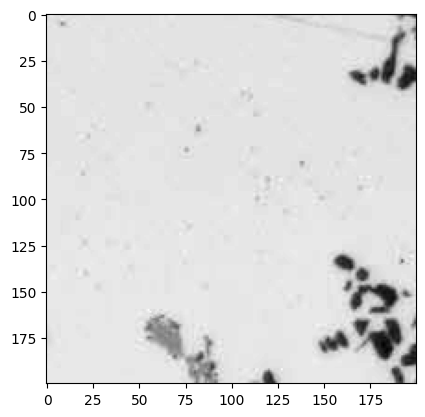

In [24]:
# Convert to float32
image = X_train[1].squeeze().astype(np.float32)

# Plot the image
plt.imshow(image, cmap='gray')
plt.show()

In [25]:
Y_train[1]

0.636

### Check histogramm for image values

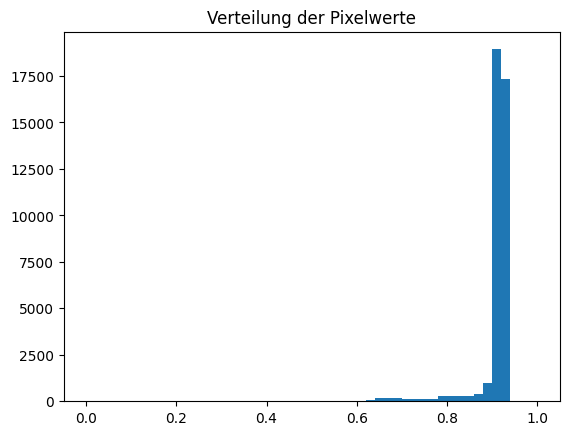

In [26]:
plt.hist(X_train[1].flatten(), bins=50, range=(0, 1))
plt.title('Verteilung der Pixelwerte')
plt.show()

In [27]:
print(f"Min: {np.min(X_train)}, Max: {np.max(X_train)}")

Min: 0.1412353515625, Max: 1.0


### Check if null or inf values in train_y

In [28]:
assert not np.any(np.isnan(image)), "NaN-values found"
assert not np.any(np.isinf(image)), "infinite values found"
assert X_train[5].shape == (200, 200, 1), "image has unexpected form"

### Check Data Distribution

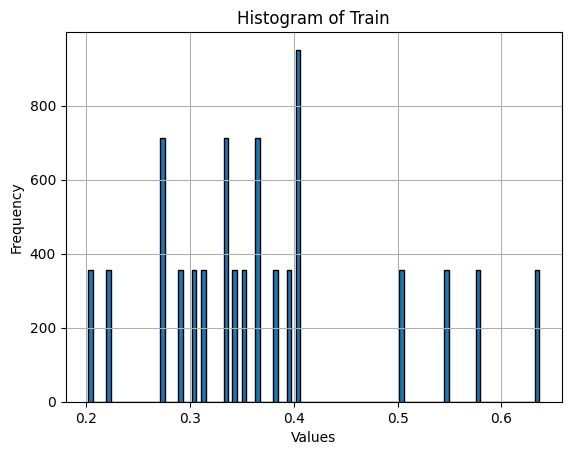

In [29]:
# Plot histogram
plt.hist(Y_train, bins=100, edgecolor='black')  # 100 bins, black edges
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram of Train")
plt.grid(True)

# Show the plot
plt.show()

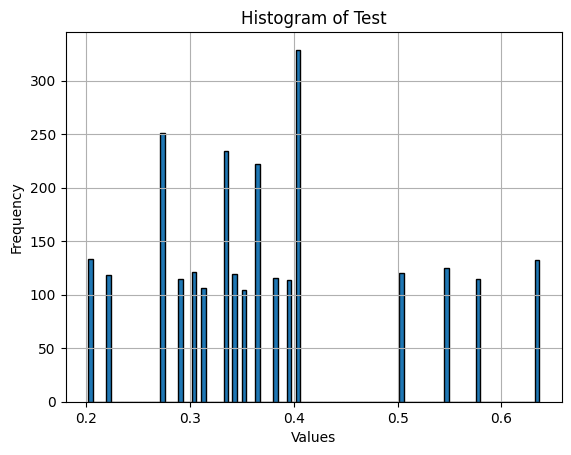

In [30]:
# Plot histogram
plt.hist(Y_test, bins=100, edgecolor='black')  # 100 bins, black edges
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram of Test")
plt.grid(True)

# Show the plot
plt.show()

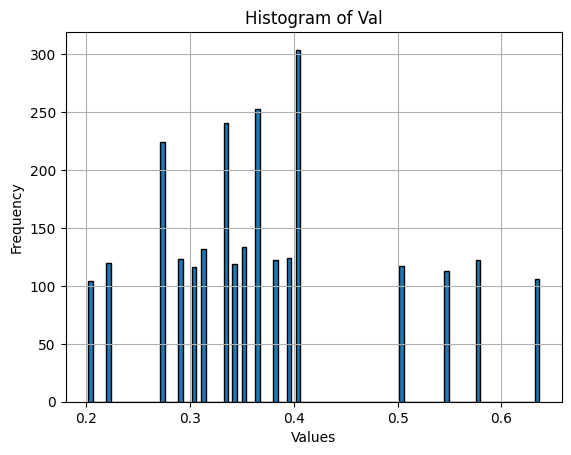

In [31]:
# Plot histogram
plt.hist(Y_val, bins=100, edgecolor='black')  # 100 bins, black edges
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram of Val")
plt.grid(True)

# Show the plot
plt.show()

## Training

In [32]:
logdir = r'..\logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [33]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    r'..\checkpoints\best_weights.weights.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

*It was trained with the Keras library on an Intel® Core™ I7-4970 CPU running at 3.60 GHz using 8 parallel processing units. Training was completed in 5 h—for 30 epochs total. A batch size of 32 was used for the training.* 

I will instead use my GPU, since its simply way faster.

In [34]:
# Check if GPU's are available
gpus = tf.config.list_physical_devices('GPU')
print(f"{len(gpus)} GPUs erkannt:")
for gpu in gpus:
    print(gpu)

1 GPUs erkannt:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [35]:
# If a GPU is available, enable memory growth (prevents memory issues)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


*Verify loss @ init. Verify that your loss starts at the correct loss value*

In [36]:
# Calculate the initial loss before training
init_loss = model.evaluate(X_val, Y_val, verbose=1)
print(f"Initial Loss: {init_loss[0]}")  # Should be approximately 1/3

I0000 00:00:1747221155.391475  471473 service.cc:152] XLA service 0x7f1aac003530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747221155.391589  471473 service.cc:160]   StreamExecutor device (0): NVIDIA A30 MIG 4g.24gb, Compute Capability 8.0
2025-05-14 11:12:35.554832: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/grayscale_to_rgb_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
2025-05-14 11:12:35.555320: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/grayscale_to_rgb_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert
2025-05-14 11:12:35.575478: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747221155.989454  471473 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-14 11:12:36.250281: W external/local_xla/xla/tsl/f

 6/81 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - RootMeanSquaredError: 0.8662 - loss: 0.7504

I0000 00:00:1747221158.041635  471473 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - RootMeanSquaredError: 0.8726 - loss: 0.7614

2025-05-14 11:12:39.843824: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/grayscale_to_rgb_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
2025-05-14 11:12:39.843939: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/grayscale_to_rgb_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert


81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - RootMeanSquaredError: 0.8726 - loss: 0.7614
Initial Loss: 0.7603969573974609


In [37]:
# CALLBACKS (optional)

# EarlyStopping callback, stops training when validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# ModelCheckpoint callback, saves the best model based on validation loss
# checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

def scheduler(epoch, lr): # Exponential Decay
    decay_rate = 0.90     # reduced 10% every decay_epochs...
    decay_epoch = 100     
    return lr * decay_rate**(epoch // decay_epoch)

lr_scheduler = LearningRateScheduler(scheduler)

# HYPERPARAMETER

batch_size = 32    # the original paper used a batch size of 32
epochs = 1000       # the original paper used 30 epochs 
shuffle = True

hist = model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),  # Use the generator here
    epochs=epochs,
    validation_data=(X_val, Y_val),
    shuffle=shuffle,
    verbose=0,  # muss 0 sein für tqdm 
    callbacks=[TqdmCallback(verbose=1), early_stopping, lr_scheduler] 
    #callbacks=[TqdmCallback(verbose=1, leave=True, tqdm_class=tqdm)]  # klassisch, kein Widget -> bug fix?
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/opt/conda/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-05-14 11:12:46.043437: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/grayscale_to_rgb_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
2025-05-14 11:12:46.044289: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/grayscale_to_rgb_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert
2025-05-14 11:12:51.881022: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/grayscale_to_rgb_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
2025-05-14 11:12:51.881140: W tensorflow/compiler/tf2xla/kernels/ass

## Plot Train, Test and Val Loss

*add significant digits to your eval. When plotting the test loss run the evaluation over the entire (large) test set. Do not just plot test losses over batches and then rely on smoothing them in Tensorboard. We are in pursuit of correctness and are very willing to give up time for staying sane.*

In [38]:
# Evaluation on the entire test set
test_loss = model.evaluate(X_test, Y_test, batch_size = 1, verbose=1)

2025-05-14 11:45:38.547251: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/grayscale_to_rgb_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
2025-05-14 11:45:38.547384: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator functional_1/grayscale_to_rgb_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert
2025-05-14 11:45:39.255897: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 290.12MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2574/2574 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - RootMeanSquaredError: 0.0795 - loss: 0.0063


In [39]:
print(hist.history.keys())

dict_keys(['RootMeanSquaredError', 'loss', 'val_RootMeanSquaredError', 'val_loss', 'learning_rate'])


In [40]:
print(hist.history)

{'RootMeanSquaredError': [0.4356365203857422, 0.36969229578971863, 0.34183216094970703, 0.318093478679657, 0.29500529170036316, 0.272821307182312, 0.2517474889755249, 0.23163895308971405, 0.21185103058815002, 0.19406604766845703, 0.17559078335762024, 0.1597389280796051, 0.14531612396240234, 0.13272704184055328, 0.11973506957292557, 0.11199817061424255, 0.1050868108868599, 0.0988793596625328, 0.09582599997520447, 0.09332853555679321, 0.09342944622039795, 0.09170449525117874, 0.0900823101401329, 0.08986237645149231, 0.08865728974342346, 0.08924020826816559, 0.08957763016223907, 0.08869320154190063, 0.08721080422401428, 0.08760831505060196, 0.08780691027641296, 0.08797129988670349, 0.08668510615825653, 0.08654151856899261, 0.08657751232385635, 0.08741245418787003, 0.08610294759273529, 0.08553612977266312, 0.086189404129982, 0.08471201360225677, 0.08395806699991226, 0.08451663702726364, 0.08347992599010468, 0.0834568440914154, 0.08428198844194412, 0.08422776311635971, 0.08401934802532196, 

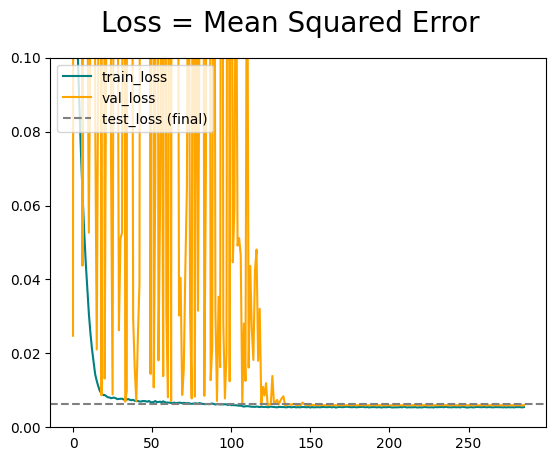

In [41]:
# Mean Squared Errors (Loss)
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='train_loss') # , marker='.' for akk exact points of graph
plt.plot(hist.history['val_loss'], color='orange', label='val_loss') # , marker='.' for akk exact points of graph
plt.axhline(y=test_loss[0], color='gray', linestyle='--', label='test_loss (final)')
plt.ylim(0, 0.1) # try commenting this...
fig.suptitle('Loss = Mean Squared Error', fontsize=20)
plt.legend(loc="upper left")
plt.show()

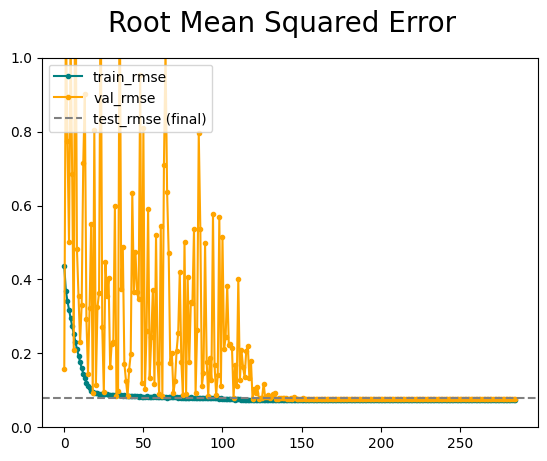

In [42]:
# # Root Mean Squared Errors (Metric) 
fig = plt.figure()
plt.plot(hist.history['RootMeanSquaredError'], color='teal', label='train_rmse', marker='.') # depends on tensorflow version if root_mean_squared_error or RootMeanSquaredError
plt.plot(hist.history['val_RootMeanSquaredError'], color='orange', label='val_rmse', marker='.')
plt.axhline(y=test_loss[1], color='gray', linestyle='--', label='test_rmse (final)')
plt.ylim(0, 1)
fig.suptitle('Root Mean Squared Error', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate Performance

The labels from the paper are in a range from 0.06 to 0.65.

### Performance

In [43]:
mse = MeanSquaredError()
rmse = RootMeanSquaredError()
mape = MeanAbsolutePercentageError()
mae = MeanAbsoluteError()

In [44]:
batch_size = 1  # If your model was trained with batches (for a more accurate test, it's still better to use 1)

y_true = []
y_pred = []

# Calculate metrics over all test data in batches
for i in range(0, len(X_test), batch_size):
    X_batch = X_test[i:i+batch_size]  # Take a batch of test data
    y_batch = Y_test[i:i+batch_size]  # Corresponding labels
    yhat_batch = model.predict(X_batch, verbose=0)  # Model prediction for the batch
    
    # Store true values and predictions
    y_true.append(y_batch)
    y_pred.append(yhat_batch)

    # Update metrics
    mse.update_state(y_batch, yhat_batch)
    rmse.update_state(y_batch, yhat_batch)
    mae.update_state(y_batch, yhat_batch)
    mape.update_state(y_batch, yhat_batch)
    
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

# R²-Score
r2 = r2_score(y_true, y_pred)

In [45]:
print(f"Mean Squared Error (MSE): {mse.result().numpy():.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse.result().numpy():.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape.result().numpy():.2f}%")
print(f"Mean Absolute Error (MAPE): {mae.result().numpy():.2f}")
print(f"R²-Score: {r2}")

Mean Squared Error (MSE): 0.0063
Root Mean Squared Error (RMSE): 0.0796
Mean Absolute Percentage Error (MAPE): 16.28%
Mean Absolute Error (MAPE): 0.06
R²-Score: 0.481222927570343


## Predict SDAS for some specific test image

(200, 200, 1)


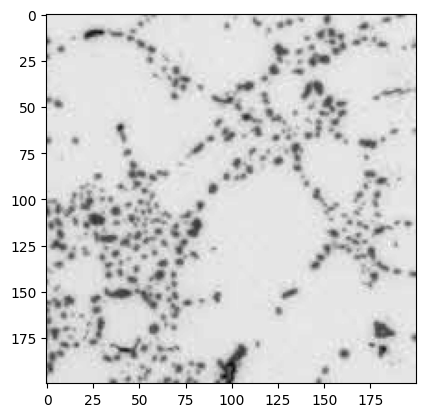

In [46]:
test_index = 1001
test_image = X_test[test_index]
test_label = Y_test[test_index]

print(test_image.shape)

# Convert Image to float32 numpy array
image = test_image.squeeze().astype(np.float32)

# Plot the image
plt.imshow(image, cmap='gray')
plt.show()

In [47]:
print(np.expand_dims(test_image, axis=0).shape)

(1, 200, 200, 1)


In [48]:
yhat = model.predict(np.expand_dims(test_image, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [49]:
print("Ground Truth S_value: ", test_label*100)
print("Predicted S_value: ", round(yhat[0][0] * 100, 2))

Ground Truth S_value:  27.2705078125
Predicted S_value:  26.1


## Export Model

In [50]:
model.save(os.path.join(r'../models', 'ResNet50_v3.keras'))

## Make Predictions on real images

In [51]:
#test_dataset_version = "bmw_data" #210 images

test_dir = r'../data/bmw_test' 

In [52]:
min_size = 200

results = []

# for all images in test_dir
for idx, img_name in enumerate(os.listdir(test_dir)):
    if img_name.endswith('.jpg') or img_name.endswith('.png'):
        
        img_path = os.path.join(test_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        height, width = img.shape
        
        # Calculate the number of tiles
        rows = height // min_size
        cols = width // min_size
        
        # Split the image into tiles
        images = []
        for i in range(rows):
            for j in range(cols):
                y_start = i * min_size
                x_start = j * min_size
                y_end = min(y_start + min_size, height)
                x_end = min(x_start + min_size, width)
                image = img[y_start:y_end, x_start:x_end]
                images.append(image)
        
        # Collect model predictions
        predictions = []
        for image in images:
            image = image.astype(np.float16) / 255.0  # normalize to [0, 1]
            image_resized = tf.image.resize(image[..., np.newaxis], (200, 200))  # add channel dimension            
            prediction = model.predict(np.expand_dims(image_resized, axis=0), verbose=0)[0][0]
            predictions.append(prediction)
        
        # Calculate the prediction
        S_value_pred = np.median(predictions) * 100 # * 100, because we normalized the data when we imported it 
        
        SDAS_pred = S_value_pred * F_value  
        
        # Extract the actual SDAS value from the filename
        try:
            SDAS_true = float(img_name.split('_')[1])
            results.append((SDAS_true, SDAS_pred))
        except:
            print(f"Warning: Couldn't extract SDAS-value from '{img_name}'!")

        if idx % 5 == 0:
            print(f"⏳ Processed {idx}/{len(os.listdir(test_dir))} images...")

⏳ Processed 0/81 images...



KeyboardInterrupt



In [ ]:
# Separate true and predicted values
y_true = [true for true, pred in results]
y_pred = [pred for true, pred in results]

# Calculate the metrics
SDAS_mse = mean_squared_error(y_true, y_pred)
SDAS_rmse = np.sqrt(SDAS_mse)
SDAS_mae = mean_absolute_error(y_true, y_pred)
SDAS_r2 = r2_score(y_true, y_pred)

# MAPE (with protection against division by zero)
y_true_array = np.array(y_true)
y_pred_array = np.array(y_pred)
SDAS_mape = np.mean(np.abs((y_true_array - y_pred_array) / y_true_array)) * 100

# Output the results
print(f"MSE: {SDAS_mse:.4f}")
print(f"RMSE: {SDAS_rmse:.4f}")
print(f"MAE: {SDAS_mae:.4f}")
print(f"MAPE: {SDAS_mape:.2f}%")
print(f"R²: {SDAS_r2:.4f}")

In [ ]:
len(y_true_array)

In [ ]:
#plotting predicted vs ground truth SDAS values for all images

plt.figure(figsize=(6, 6))  
plt.plot([0, 100], [0, 100], 'r--')  # Reference diagonal line
plt.scatter(y_true_array, y_pred_array)
plt.xlabel("Ground Truth SDAS")
plt.ylabel("Predicted SDAS")
plt.axis("equal")  # Ensure equal scaling on both axes
plt.title("Predicted vs. Ground Truth SDAS")
plt.show()

## Showing Sclices Predictions for an given image

In [ ]:
def process_image(test_dir, img_name, model):
    img_path = os.path.join(test_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    height, width = img.shape
    
    # Calculate the number of tiles
    rows = height // min_size
    cols = width // min_size
    
    # Split the image into tiles
    images = []
    predictions = []
    for i in range(rows):
        for j in range(cols):
            y_start = i * min_size
            x_start = j * min_size
            y_end = min(y_start + min_size, height)
            x_end = min(x_start + min_size, width)
            image = img[y_start:y_end, x_start:x_end]
            images.append(image)
            
            # Normalize and resize the image for prediction
            image = image.astype(np.float16) / 255.0  # normalize to [0, 1]
            image_resized = tf.image.resize(image[..., np.newaxis], (200, 200))  # Add channel dimension            
            prediction = model.predict(np.expand_dims(image_resized, axis=0), verbose=0)[0][0]
            predictions.append(prediction * 100 * F_value)
    
    return img, predictions, rows, cols

def plot_heatmap_with_image(img, predictions, rows, cols, min_size):
    # Reshape predictions to match the number of tiles
    heatmap = np.array(predictions).reshape((rows, cols))
    
    # Create a figure
    plt.figure(figsize=(10, 10))
    
    # Display the original image
    plt.imshow(img, cmap='gray', extent=[0, img.shape[1], img.shape[0], 0])
    
    # Overlay the heatmap on top of the image
    plt.imshow(heatmap, cmap='jet', alpha=0.5, extent=[0, img.shape[1], img.shape[0], 0])
    
    # Add color bar (legend for the heatmap)
    cbar = plt.colorbar()
    cbar.set_label('SDAS Prediction')

    # Show the plot
    plt.title("Image with SDAS Heatmap Overlay")
    plt.show()

In [ ]:
test_dir = r'../data/bmw_test'
img_name = 'AC_39_B9.jpg'  # Replace with the image you want to test

# Process the selected image
img, predictions, rows, cols = process_image(test_dir, img_name, model)

In [ ]:
print(np.median(predictions))

# Plot the heatmap over the image
plot_heatmap_with_image(img, predictions, rows, cols, min_size)

## ML-Flow 

In [ ]:
!pip install --user mlflow
!pip install mlflow

In [ ]:
import mlflow
import mlflow.keras
from mlflow.tracking import MlflowClient

Tutorial: https://www.youtube.com/watch?v=6ngxBkx05Fs&ab_channel=codebasics

What do we want to log for every run:
- model (with summary)
- hyperparameter
- dataset version
- metrics
- notebook

Run "mlflow ui" in your CMD first!

In [ ]:
!mlflow --version

In [ ]:
mlflow.set_experiment("SDAS_Prediciton")
mlflow.set_tracking_uri("file:../mlruns")

with mlflow.start_run(run_name = 'v1_CNN_paperArchitecture_bmw_unaugmented'): # change with every run 
    
    # Save hyperparameters
    
    mlflow.log_params({
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'epochs': epochs,
        'shuffle': shuffle,
        'optimizer': optimizer,
        # Save Data
        #'dataset_version': dataset_version,  
        #'test_dataset_version': test_dataset_version,
        'pixel_per_µm': pixel_per_µm
    }) 
    
    # Save metrics
    
    mlflow.log_metrics({
        'S_norm_Mean Squared Error': mse.result().numpy(),
        'S_norm_Root Mean Squared Error': rmse.result().numpy(), 
        'S_norm_Mean Absolute Percentage Error': mape.result().numpy(),
        'S_norm_Mean Absolute Error': mae.result().numpy(),
        'S_norm_R2-Score': r2,
        'SDAS_Mean Squared Error': SDAS_mse,
        'SDAS_Root_Mean Squared Error': SDAS_rmse,
        'SDAS_Mean Absolute Percentage Error': SDAS_mape, 
        'SDAS_Mean Absolute Error': SDAS_mae,
        'SDAS_R2-Score': SDAS_r2
    }) 
    
    # Save model
    
    if isinstance(model, tf.keras.Model):
        mlflow.keras.log_model(model, artifact_path="cnn_model")
    else:
        print("The model isn't from the type tf.keras.Model!") 
        
    # Save notebook
    
    mlflow.log_artifact("CNN_SDAS_Prediction_Pipeline.ipynb", artifact_path="notebooks") # Name of notebook has to be correct

## Load model from ML-Flow

In [ ]:
# Enter RunID and Path
run_id = input("Enter your RunID: ")  # Ersetze mit deiner RunID
model_path = "cnn_model"

# load model
loaded_model = mlflow.keras.load_model(f"runs:/{run_id}/{model_path}")

# print model architecture
loaded_model.summary()

In [ ]:
y_pred = loaded_model.predict(X_test)
y_pred[:4]

In [ ]:
# optional

client = MlflowClient()

# load hyperparameter and metrcis
run_data = client.get_run(run_id).data
print("Hyperparameter:", run_data.params)
print("Metriken:", run_data.metrics)

# download current notebook
client.download_artifacts(run_id, f"notebooks_from_mlflow/{run_id}.ipynb", "./")